In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import itertools 
from sklearn import svm
import spark

ModuleNotFoundError: No module named 'imblearn'

In [5]:
pip install spark

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58748 sha256=f1475cb22961217d948de2876845f205972028a4c06935becfc50e92673b61e6
  Stored in directory: /home/victorletzelter/.cache/pip/wheels/63/88/77/b4131110ea4094540f7b47c6d62a649807d7e94800da5eab0b
Successfully built spark
Note: you may need to restart the kernel to use updated packages.


In [6]:
df = spark.sql("select * from race_gold10").toPandas()

NameError: name 'spark' is not defined

In [0]:
def model_prep(df:pd.DataFrame,current_year:int,first_year:int,finish_only:bool,ohe_cols:list,drop_cols:list,remove_quali:bool):
    
    #do not include pre season testing
    df = df[df.event != "Pre-Season Test"]
    df = df[df.event != "Pre-Season Test 1"]
    df = df[df.event != "Pre-Season Test 2"]
    
    #datafixes for quali time (should be taken care of in quali silver)
    df['final_quali_time'].fillna(0,inplace=True)
    df['rel_time_delta'].fillna(0.1,inplace=True)

    
    #dataframe limited by first year
    df = df[(df.year >= first_year)]
    
    
    
    #dataframe for drivers that finish a race (exclude driver retirement)
    if finish_only:
        df = df[(df.Status_Finished == 1) | (df.Status_Other == 1)]

    #create a testing df with only current year
    df_current_yr = df[(df.year == current_year)]
    
    ohe_list = []

    #get unique events for the current year
    unique_event = df_current_yr.event.unique()
    event = list(["event_" + s.replace(" ", "_") for s in unique_event])
    if 'event' in ohe_cols:
        ohe_list.append(event)
        
    #get unique drivers for the current year
    unique_driver = df_current_yr.FullName.unique()
    fullname = list(["FullName_" + s.replace(" ", "_") for s in unique_driver])
    if 'fullname' in ohe_cols:
        ohe_list.append(fullname)
        
    #get unique teams for the current year
    unique_team = df_current_yr.TeamName.unique()
    teamname = list(["TeamName_" + s.replace(" ", "_") for s in unique_team])
    if 'teamname' in ohe_cols:
        ohe_list.append(teamname)
        
    #create a list of agg cols 
    gridpos = list(df.filter(regex='front_row|time').columns)
    
    if remove_quali:
        df.drop(gridpos, axis = 1, inplace=True)
        df.drop(["GridPosition"], axis = 1, inplace=True)
        print(gridpos)
        
    agg_cols = list(df.filter(regex='GridPosition|mean|count|sum|time|year|front_row|isfirst|istoptwo|ispodium').columns)
    
    #combine ohe cols
    opt_ohe = list(itertools.chain.from_iterable(ohe_list))
    
    #combine agg cols and ohe cols into one list
    opt = list(itertools.chain(agg_cols,opt_ohe))
    
    df_train = df[opt]
    
    df_test = df_current_yr[opt]
    
    #drop cols not needed (should be taken care of in gold)
    add_drop = list(df.filter(regex='max_').columns)
    drop_cols = list(itertools.chain(drop_cols,add_drop))
    
    if len(drop_cols) > 0:
        df_train.drop(drop_cols, axis = 1, inplace=True)
        df_test.drop(drop_cols, axis = 1, inplace=True)
        
    return df_train,df_test,df_current_yr


In [0]:
def acc_fun(df_test,prob,sort_by,target,include_gridpos):
    
    #create a subset of df_test
    df_test = df_test[['TeamName','FullName','event','EventDate','Position','GridPosition']]  
    
    #add probability to df_test by index
    df_test[f'prob_{target}'] = prob   
    
    #reshuffle df_test and remove index to induce complete randomness
    df_test = df_test.sample(frac=1,random_state=42).reset_index(drop=True)
    
    #print(df_test[df_test.event == "Italian Grand Prix"])
    
    #create a df with Position and Grid Position to check accuracy
    if include_gridpos:
        df_test = df_test
    else:
        df_test.drop(['GridPosition'], axis = 1)
    
    #resort df_test to order by date (and grid position if needed)
    df_resort = df_test.sort_values(by=sort_by)
    
    #print(df_resort[df_resort.event == "Italian Grand Prix"])
    
    #print(df_resort.head(20))

    df_resort[f'rank_{target}'] = df_resort.groupby(['event'])[f'prob_{target}'].rank(method='first',ascending=False)

    #print(df_resort[df_resort.event == "Italian Grand Prix"])
    
    df_final = df_resort
    #df_final = df_resort.merge(df_testing_position_join, how='left', on=['TeamName','FullName','EventDate','event'])
    
    #df_final = df_final.merge(df_testing_gridpos_join, how='left', on=['TeamName','FullName','EventDate','event'])
    
    df_final_first = df_final[df_final['Position']==1]
    
    df_final_podium = df_final
    df_final_podium['podium_predict'] = np.where((df_final_podium[f'rank_{target}'] == 1) | (df_final_podium[f'rank_{target}'] == 2) | (df_final_podium[f'rank_{target}'] == 3), True,False)
    df_final_podium['podium'] = np.where((df_final_podium.Position == 1) | (df_final_podium.Position == 2) | (df_final_podium.Position == 3), True, False)

    print("First Place Accuracy:",metrics.accuracy_score(df_final_first['Position'], df_final_first[f'rank_{target}']))
    print("Podium Accuracy:",metrics.accuracy_score(df_final_podium['podium'], df_final_podium['podium_predict']))
    print("Total Accuracy:",metrics.accuracy_score(df_final['Position'], df_final[f'rank_{target}']))
    
    return df_final

In [0]:
def model_train(df_train,df_test,df_current_yr,target,include_gridpos):

    train = df_train
    #print(df_train.columns)
    X_train = train.drop(['isfirst','istoptwo','ispodium'], axis = 1)
    y_train = train[target]
    
    #print(X_train.columns)

    test = df_test
    x_test = test.drop(['isfirst','istoptwo','ispodium'], axis = 1)
    y_test = test[target]

    scaler = StandardScaler()
    #X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

    over = RandomOverSampler(sampling_strategy=1, random_state=42)
    
    model = xgb.XGBClassifier(max_depth = 2, n_estimators = 200, learning_rate=0.01,gamma=0,reg_alpha=0,reg_lambda = 0.6,use_label_encoder=False,eval_metric='logloss',objective='binary:logistic', random_state=69)
    
    #model = xgb.XGBClassifier(max_depth = 6, min_child_weight=9.0, n_estimators = 180, learning_rate=0.01,gamma=2.1,reg_alpha=150.0,reg_lambda = 0.6,use_label_encoder=False,eval_metric='logloss',objective='binary:logistic')

    #model = xgb.XGBClassifier(colsample_bytree=0.6,gamma=2,max_depth=5,min_child_weight=5,subsample=1)

    steps = [('o',over),('m', model)]

    pipeline = Pipeline(steps)
    pipeline.fit(X_train, y_train)

    #x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

    #calculate probabilities from prediction
    proba = pipeline.predict_proba(x_test)[:, 1]
    
    sort_by = ['EventDate','event']
    
    if include_gridpos:
        sort_by = ['EventDate','event','GridPosition']
    #print(sort_by)
    
    df_final = acc_fun(df_current_yr,proba,sort_by,target,include_gridpos)
    
    return df_final[['TeamName','FullName','event','GridPosition','Position',f'rank_{target}',f'prob_{target}']], pipeline

In [0]:
#df_train,df_test = model_prep(df,current_year=2021,first_year=1950,finish_only=False,ohe_cols=['event','fullname','teamname'],drop_cols=['year'],gridpos=True)
#df_train,df_test = model_prep(df,current_year=2021,first_year=1950,finish_only=False,ohe_cols=[],drop_cols=['year'],gridpos=True)
#df_train,df_test = model_prep(df,current_year=2021,first_year=1950,finish_only=False,ohe_cols=['event','fullname','teamname'],drop_cols=['year'],gridpos=False)
df_train,df_test,df_current_yr = model_prep(df,current_year=2021,first_year=1950,finish_only=False,ohe_cols=[],drop_cols=['year'],remove_quali=True)

#print(df_train.columns)
#print(df_test.columns)

['final_quali_time', 'best_quali_time', 'rel_time_delta', 'front_row']

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
df_final_first, pipeline1 = model_train(df_train,df_test,df_current_yr,"isfirst",False)
df_final_top2, pipeline2 = model_train(df_train,df_test,df_current_yr,"istoptwo",False)
df_final_podium, pipeline3 = model_train(df_train,df_test,df_current_yr, "ispodium",False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
First Place Accuracy: 0.36363636363636365
Podium Accuracy: 0.8997722095671982
Total Accuracy: 0.11161731207289294

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
First Place Accuracy: 0.36363636363636365
Podium Accuracy: 0.8997722095671982
Total Accuracy: 0.10478359908883828
First Place Accuracy: 0.36363636363636365
Podium Accuracy: 0.908883826879271
Total Accuracy: 0.11389521640091116

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [0]:
df_final = df_final_first
df_final['ave_prob'] = (df_final_first['prob_isfirst'] * 1.05 + df_final_top2['prob_istoptwo'] * 1.01 + df_final_podium['prob_ispodium']) * 1.03 / 3
df_final['ave_rank'] = df_final.groupby(['event'])['ave_prob'].rank(method='first',ascending=False)

In [0]:
df_show = df_final[df_final.event != "Pre-Season Test"]
df_show = df_show[df_show.event != "Pre-Season Test 1"]
df_show = df_show[df_show.event != "Pre-Season Test 2"]

display(df_show[(df_show.Position == 1)].groupby("ave_rank")['ave_rank'].count())

ave_rank
1.0     8
2.0     8
3.0     2
5.0     1
7.0     1
9.0     1
13.0    1
Name: ave_rank, dtype: int64

In [0]:
df_final = df_final_first
df_show = df_final[df_final.event != "Pre-Season Test"]
df_show = df_show[df_show.event != "Pre-Season Test 1"]
df_show = df_show[df_show.event != "Pre-Season Test 2"]

display(df_show[(df_show.Position == 1)].groupby("rank_isfirst")['rank_isfirst'].count())

rank_isfirst
1.0    15
2.0     5
3.0     2
Name: rank_isfirst, dtype: int64

In [0]:
df_final = df_final_top2
df_show = df_final[df_final.event != "Pre-Season Test"]
df_show = df_show[df_show.event != "Pre-Season Test 1"]
df_show = df_show[df_show.event != "Pre-Season Test 2"]

display(df_show[(df_show.Position == 1)].groupby("rank_istoptwo")['rank_istoptwo'].count())

rank_istoptwo
1.0    13
2.0     5
3.0     2
4.0     2
Name: rank_istoptwo, dtype: int64

In [0]:
df_final = df_final_podium
df_show = df_final[df_final.event != "Pre-Season Test"]
df_show = df_show[df_show.event != "Pre-Season Test 1"]
df_show = df_show[df_show.event != "Pre-Season Test 2"]

display(df_show[(df_show.Position == 1)].groupby("rank_ispodium")['rank_ispodium'].count())

rank_ispodium
1.0    12
2.0     6
4.0     3
7.0     1
Name: rank_ispodium, dtype: int64

In [0]:
display(df_show[((df_show.rank_ispodium == 1) & ((df_show.Position == 1) | (df_show.Position == 2) | (df_show.Position == 3))) | ((df_show.rank_ispodium == 2) & ((df_show.Position == 1) | (df_show.Position == 2) | (df_show.Position == 3))) | ((df_show.rank_ispodium == 3) & ((df_show.Position == 1) | (df_show.Position == 2) | (df_show.Position == 3)))].groupby("event")['Position'].count())

event
Abu Dhabi Grand Prix         3
Austrian Grand Prix          2
Azerbaijan Grand Prix        1
Bahrain Grand Prix           3
Belgian Grand Prix           2
British Grand Prix           2
Dutch Grand Prix             3
Emilia Romagna Grand Prix    2
French Grand Prix            2
Hungarian Grand Prix         1
Italian Grand Prix           2
Mexico City Grand Prix       3
Monaco Grand Prix            2
Portuguese Grand Prix        3
Qatar Grand Prix             2
Russian Grand Prix           3
Saudi Arabian Grand Prix     3
Spanish Grand Prix           3
Styrian Grand Prix           3
São Paulo Grand Prix         2
Turkish Grand Prix           2
United States Grand Prix     3
Name: Position, dtype: int64

In [0]:
display(df_show[(df_show.ave_rank == 1)].sort_values(by=['event','Position']))

TeamName,FullName,event,GridPosition,Position,rank_isfirst,prob_isfirst,ave_prob,ave_rank
Red Bull Racing,Max Verstappen,Abu Dhabi Grand Prix,1.0,1.0,1.0,0.8411502,0.9157519,1.0
Red Bull Racing,Max Verstappen,Austrian Grand Prix,1.0,1.0,1.0,0.87826806,0.9322217,1.0
Red Bull Racing,Max Verstappen,Azerbaijan Grand Prix,3.0,18.0,1.0,0.87611896,0.9306945,1.0
Mercedes,Lewis Hamilton,Bahrain Grand Prix,2.0,1.0,1.0,0.8913951,0.93591326,1.0
Red Bull Racing,Max Verstappen,Belgian Grand Prix,1.0,1.0,1.0,0.8575505,0.9116015,1.0
Red Bull Racing,Max Verstappen,British Grand Prix,1.0,20.0,1.0,0.87826806,0.92791295,1.0
Red Bull Racing,Max Verstappen,Dutch Grand Prix,1.0,1.0,1.0,0.8777344,0.9315357,1.0
Mercedes,Lewis Hamilton,Emilia Romagna Grand Prix,1.0,2.0,1.0,0.89033586,0.93876344,1.0
Red Bull Racing,Max Verstappen,French Grand Prix,1.0,1.0,2.0,0.8640264,0.9136119,1.0
Mercedes,Lewis Hamilton,Hungarian Grand Prix,1.0,2.0,3.0,0.7014251,0.8447191,1.0


In [0]:
display(df_show[(df_show.FullName == 'Daniel Ricciardo')].sort_values(by=['event','Position']))

TeamName,FullName,event,GridPosition,Position,rank_isfirst,prob_isfirst,ave_prob,ave_rank
McLaren,Daniel Ricciardo,Abu Dhabi Grand Prix,10.0,12.0,9.0,0.10421655,0.1598814,9.0
McLaren,Daniel Ricciardo,Austrian Grand Prix,13.0,7.0,8.0,0.18021312,0.18816656,9.0
McLaren,Daniel Ricciardo,Azerbaijan Grand Prix,13.0,9.0,7.0,0.116730034,0.20008457,10.0
McLaren,Daniel Ricciardo,Bahrain Grand Prix,6.0,7.0,8.0,0.13420425,0.2591096,5.0
McLaren,Daniel Ricciardo,Belgian Grand Prix,4.0,4.0,9.0,0.10069353,0.18552357,10.0
McLaren,Daniel Ricciardo,British Grand Prix,6.0,5.0,9.0,0.08751465,0.14780699,9.0
McLaren,Daniel Ricciardo,Dutch Grand Prix,10.0,11.0,11.0,0.070588276,0.13658108,9.0
McLaren,Daniel Ricciardo,Emilia Romagna Grand Prix,6.0,6.0,4.0,0.20849098,0.29342172,4.0
McLaren,Daniel Ricciardo,French Grand Prix,10.0,6.0,8.0,0.17590697,0.22534625,9.0
McLaren,Daniel Ricciardo,Hungarian Grand Prix,11.0,11.0,7.0,0.15340212,0.17305952,9.0


In [0]:
display(df_show[(df_show[df_show.sort_values(by=['event','Position'])])

  File "<command-634249203105787>", line 1
    display(df_show[(df_show[df_show.sort_values(by=['event','Position'])])
                                                                           ^
SyntaxError: unexpected EOF while parsing


In [0]:
display(df_show.sort_values(by=['event','Position']))

TeamName,FullName,event,GridPosition,Position,rank_isfirst,prob_isfirst,ave_prob,ave_rank
Red Bull Racing,Max Verstappen,Abu Dhabi Grand Prix,1.0,1.0,1.0,0.87203664,0.93158823,1.0
Mercedes,Lewis Hamilton,Abu Dhabi Grand Prix,2.0,2.0,2.0,0.8022849,0.8807857,2.0
Ferrari,Carlos Sainz,Abu Dhabi Grand Prix,5.0,3.0,5.0,0.111806534,0.37079546,4.0
AlphaTauri,Yuki Tsunoda,Abu Dhabi Grand Prix,8.0,4.0,18.0,0.06634744,0.07983034,15.0
AlphaTauri,Pierre Gasly,Abu Dhabi Grand Prix,12.0,5.0,7.0,0.09951093,0.14600714,9.0
Mercedes,Valtteri Bottas,Abu Dhabi Grand Prix,6.0,6.0,3.0,0.2532589,0.3877637,3.0
McLaren,Lando Norris,Abu Dhabi Grand Prix,3.0,7.0,4.0,0.12656899,0.24181145,6.0
Alpine,Fernando Alonso,Abu Dhabi Grand Prix,11.0,8.0,14.0,0.06728163,0.18623848,8.0
Alpine,Esteban Ocon,Abu Dhabi Grand Prix,9.0,9.0,17.0,0.06657212,0.07750349,17.0
Ferrari,Charles Leclerc,Abu Dhabi Grand Prix,7.0,10.0,6.0,0.1046072,0.20081873,7.0


In [0]:
display(df_show[((df_show.Position == 1) | (df_show.Position == 2) | (df_show.Position == 3)) | ((df_show.rank_isfirst == 1) | (df_show.rank_isfirst == 2) | (df_show.rank_isfirst == 3))].sort_values(by=['event','Position']))

TeamName,FullName,event,GridPosition,Position,rank_isfirst,prob_isfirst,ave_prob,ave_rank
Red Bull Racing,Max Verstappen,70th Anniversary Grand Prix,4.0,1.0,2.0,0.832483,0.88881636,2.0
Mercedes,Lewis Hamilton,70th Anniversary Grand Prix,2.0,2.0,1.0,0.8856407,0.93437177,1.0
Mercedes,Valtteri Bottas,70th Anniversary Grand Prix,1.0,3.0,3.0,0.7980152,0.82968074,3.0
Red Bull Racing,Max Verstappen,Abu Dhabi Grand Prix,1.0,1.0,2.0,0.8477819,0.90748477,2.0
Mercedes,Valtteri Bottas,Abu Dhabi Grand Prix,2.0,2.0,3.0,0.7263791,0.85352635,3.0
Mercedes,Lewis Hamilton,Abu Dhabi Grand Prix,3.0,3.0,1.0,0.9011045,0.9163893,1.0
Mercedes,Valtteri Bottas,Austrian Grand Prix,1.0,1.0,1.0,0.8679909,0.9064536,1.0
Ferrari,Charles Leclerc,Austrian Grand Prix,7.0,2.0,4.0,0.22771032,0.60395783,3.0
McLaren,Lando Norris,Austrian Grand Prix,3.0,3.0,7.0,0.0827773,0.34206143,6.0
Red Bull Racing,Alexander Albon,Austrian Grand Prix,4.0,13.0,3.0,0.42043954,0.3915712,5.0


In [0]:
display(df_show[((df_show.rank_ispodium == 1) | (df_show.rank_ispodium == 2) | (df_show.rank_ispodium == 3))].sort_values(by=['event','Position']))

TeamName,FullName,event,GridPosition,Position,rank_ispodium,prob_ispodium
Red Bull Racing,Max Verstappen,Abu Dhabi Grand Prix,1.0,1.0,1.0,0.8763081
Mercedes,Lewis Hamilton,Abu Dhabi Grand Prix,2.0,2.0,2.0,0.8509502
Ferrari,Carlos Sainz,Abu Dhabi Grand Prix,5.0,3.0,3.0,0.7792644
Red Bull Racing,Max Verstappen,Austrian Grand Prix,1.0,1.0,1.0,0.8996149
Mercedes,Valtteri Bottas,Austrian Grand Prix,5.0,2.0,3.0,0.8362966
Mercedes,Lewis Hamilton,Austrian Grand Prix,4.0,4.0,2.0,0.87648296
Red Bull Racing,Sergio Perez,Azerbaijan Grand Prix,6.0,1.0,1.0,0.8650412
Mercedes,Valtteri Bottas,Azerbaijan Grand Prix,10.0,12.0,2.0,0.8443734
Red Bull Racing,Max Verstappen,Azerbaijan Grand Prix,3.0,18.0,3.0,0.8320598
Mercedes,Lewis Hamilton,Bahrain Grand Prix,2.0,1.0,1.0,0.8920974


In [0]:
display(df_show[((df_show.rank_ispodium == 1) & ((df_show.Position == 1) | (df_show.Position == 2) | (df_show.Position == 3))) | ((df_show.rank_ispodium == 2) & ((df_show.Position == 1) | (df_show.Position == 2) | (df_show.Position == 3))) | ((df_show.rank_ispodium == 3) & ((df_show.Position == 1) | (df_show.Position == 2) | (df_show.Position == 3)))])

TeamName,FullName,event,GridPosition,Position,rank_ispodium,prob_ispodium
Red Bull Racing,Max Verstappen,Abu Dhabi Grand Prix,1.0,1.0,3.0,0.7561261
Mercedes,Lewis Hamilton,Abu Dhabi Grand Prix,2.0,2.0,1.0,0.81166536
Red Bull Racing,Max Verstappen,Austrian Grand Prix,1.0,1.0,3.0,0.7700837
Mercedes,Valtteri Bottas,Austrian Grand Prix,5.0,2.0,2.0,0.7975573
Red Bull Racing,Max Verstappen,Bahrain Grand Prix,1.0,2.0,3.0,0.75826114
Mercedes,Lewis Hamilton,Bahrain Grand Prix,2.0,1.0,1.0,0.80913323
Mercedes,Valtteri Bottas,Bahrain Grand Prix,3.0,3.0,2.0,0.8055771
Red Bull Racing,Max Verstappen,Belgian Grand Prix,1.0,1.0,3.0,0.7561261
Mercedes,Lewis Hamilton,Belgian Grand Prix,3.0,3.0,1.0,0.80144113
Mercedes,Lewis Hamilton,British Grand Prix,2.0,1.0,1.0,0.81166536


In [0]:
display(df_show[(df_show.rank_ispodium == 1) | (df_show.rank_ispodium == 2) | (df_show.rank_ispodium == 3)][['TeamName','FullName','event','GridPosition','Position','rank_ispodium','prob_ispodium']]

  File "<command-1772459361124352>", line 1
    display(df_show[(df_show.rank_ispodium == 1) | (df_show.rank_ispodium == 2) | (df_show.rank_ispodium == 3)][['TeamName','FullName','event','GridPosition','Position','rank_ispodium','prob_ispodium']]
                                                                                                                                                                                                          ^
SyntaxError: unexpected EOF while parsing


In [0]:
df_testing_position_join = df_testing[['TeamName','FullName','event','Position','EventDate']]

df_testing_event_join = df_testing[['TeamName','FullName','event','EventDate','GridPosition']]

df_testing_event_join['prob3'] = proba

df_resort = df_testing_event_join.sort_values(by=['event','GridPosition'])

df_resort['rank3'] = df_resort.groupby(['event'])['prob3'].rank(method='first',ascending=False)

df_final = df_resort.merge(df_testing_position_join, how='left', on=['TeamName','FullName','EventDate','event'])

print("Accuracy:",metrics.accuracy_score(df_final['Position'], df_final['rank3']))

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-2139776789000181> in <cell line: 1>()
----> 1 df_testing_position_join = df_testing[['TeamName','FullName','event','Position','EventDate']]
      2 
      3 df_testing_event_join = df_testing[['TeamName','FullName','event','EventDate','GridPosition']]
      4 
      5 df_testing_event_join['prob3'] = proba

NameError: name 'df_testing' is not defined

In [0]:
df_show = df_final[df_final.event != "Pre-Season Test"]
df_show = df_show[df_show.event != "Pre-Season Test 1"]
df_show = df_show[df_show.event != "Pre-Season Test 2"]

display(df_show[(df_show.Position == 1)].groupby("rank3")['rank3'].count())

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
<command-1571909853700347> in <cell line: 5>()
      3 df_show = df_show[df_show.event != "Pre-Season Test 2"]
      4 
----> 5 display(df_show[(df_show.Position == 1)].groupby("rank3")['rank3'].count())

/databricks/python/lib/python3.9/site-packages/pandas/core/frame.py in groupby(self, by, axis, level, as_index, sort, group_keys, squeeze, observed, dropna)
   7629         # error: Argument "squeeze" to "DataFrameGroupBy" has incompatible type
   7630         # "Union[bool, NoDefault]"; expected "bool"
-> 7631         return DataFrameGroupBy(
   7632             obj=self,
   7633             keys=by,

/databricks/python/lib/python3.9/site-packages/pandas/core/groupby/groupby.py in __init__(self, obj, keys, axis, level, grouper, exclusions, selection, as_index, sort, group_keys, squeeze, observed, mutated, dropna)
    887             f

In [0]:
display(df_show[((df_show.Position == 1) & (df_show.rank_istoptwo > 1)) | ((df_show.Position == 2) & (df_show.rank_istoptwo == 1)) | (df_show.Position == 1) | (df_show.Position == 2) | (df_show.rank_istoptwo == 1)][['TeamName','FullName','event','GridPosition','Position','rank_istoptwo','prob_istoptwo']].sort_values(by=['event','Position']))

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-1772459361124355> in <cell line: 1>()
----> 1 display(df_show[((df_show.Position == 1) & (df_show.rank_istoptwo > 1)) | ((df_show.Position == 2) & (df_show.rank_istoptwo == 1)) | (df_show.Position == 1) | (df_show.Position == 2) | (df_show.rank_istoptwo == 1)][['TeamName','FullName','event','GridPosition','Position','rank_istoptwo','prob_istoptwo']].sort_values(by=['event','Position']))

/databricks/python/lib/python3.9/site-packages/pandas/core/generic.py in __getattr__(self, name)
   5485         ):
   5486             return self[name]
-> 5487         return object.__getattribute__(self, name)
   5488 
   5489     def __setattr__(self, name: str, value) -> None:

AttributeError: 'DataFrame' object has no attribute 'rank_istoptwo'

In [0]:
display(df_show[((df_show.Position == 1) & (df_show.rank3 == 1))][['TeamName','FullName','event','GridPosition','Position','rank3','prob3']].sort_values(by=['event','Position']))

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-2139776789000177> in <cell line: 1>()
----> 1 display(df_show[((df_show.Position == 1) & (df_show.rank3 == 1))][['TeamName','FullName','event','GridPosition','Position','rank3','prob3']].sort_values(by=['event','Position']))

/databricks/python/lib/python3.9/site-packages/pandas/core/generic.py in __getattr__(self, name)
   5485         ):
   5486             return self[name]
-> 5487         return object.__getattribute__(self, name)
   5488 
   5489     def __setattr__(self, name: str, value) -> None:

AttributeError: 'DataFrame' object has no attribute 'rank3'

In [0]:
display(df_show[(df_show.event == "Italian Grand Prix")])

TeamName,FullName,event,GridPosition,Position,rank_isfirst,prob_isfirst,ave_prob,ave_rank
Ferrari,Carlos Sainz,Italian Grand Prix,6.0,6.0,8.0,0.115612574,0.16731553,9.0
Red Bull Racing,Max Verstappen,Italian Grand Prix,1.0,18.0,1.0,0.84736484,0.76163584,3.0
Aston Martin,Lance Stroll,Italian Grand Prix,9.0,7.0,18.0,0.067395076,0.07312151,18.0
Aston Martin,Sebastian Vettel,Italian Grand Prix,11.0,12.0,12.0,0.06865154,0.07608266,16.0
AlphaTauri,Pierre Gasly,Italian Grand Prix,21.0,19.0,5.0,0.514431,0.36748478,6.0
Haas F1 Team,Mick Schumacher,Italian Grand Prix,18.0,15.0,16.0,0.067411005,0.07156201,19.0
McLaren,Lando Norris,Italian Grand Prix,3.0,2.0,9.0,0.07375438,0.48695084,5.0
Williams,George Russell,Italian Grand Prix,14.0,9.0,11.0,0.068772785,0.12857354,11.0
Haas F1 Team,Nikita Mazepin,Italian Grand Prix,16.0,16.0,17.0,0.067411005,0.07122972,20.0
Mercedes,Valtteri Bottas,Italian Grand Prix,19.0,3.0,4.0,0.5188247,0.66898936,4.0


In [0]:
display(df_show[((df_show.GridPosition == 1) & (df_show.Position == 1))][['TeamName','FullName','event','GridPosition','Position','rank3','prob3']].sort_values(by=['event','Position']))

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
<command-2139776789000178> in <cell line: 1>()
----> 1 display(df_show[((df_show.GridPosition == 1) & (df_show.Position == 1))][['TeamName','FullName','event','GridPosition','Position','rank3','prob3']].sort_values(by=['event','Position']))

/databricks/python/lib/python3.9/site-packages/pandas/core/frame.py in __getitem__(self, key)
   3462             if is_iterator(key):
   3463                 key = list(key)
-> 3464             indexer = self.loc._get_listlike_indexer(key, axis=1)[1]
   3465 
   3466         # take() does not accept boolean indexers

/databricks/python/lib/python3.9/site-packages/pandas/core/indexing.py in _get_listlike_indexer(self, key, axis)
   1312             keyarr, indexer, new_indexer = ax._reindex_non_unique(keyarr)
   1313 
-> 1314         self._validate_read_indexer(keyarr, indexer, axis)
   1315 
   131

In [0]:
display(df[df.year ==2021][['TeamName','FullName','event','EventDate','GridPosition','Position']])

TeamName,FullName,event,EventDate,GridPosition,Position
Red Bull Racing,Max Verstappen,Pre-Season Test,2021-06-20T00:00:00.000+0000,1.0,1.0
Mercedes,Lewis Hamilton,Pre-Season Test,2021-06-20T00:00:00.000+0000,2.0,2.0
Red Bull Racing,Sergio Perez,Pre-Season Test,2021-06-20T00:00:00.000+0000,4.0,3.0
Mercedes,Valtteri Bottas,Pre-Season Test,2021-06-20T00:00:00.000+0000,3.0,4.0
McLaren,Lando Norris,Pre-Season Test,2021-06-20T00:00:00.000+0000,8.0,5.0
McLaren,Daniel Ricciardo,Pre-Season Test,2021-06-20T00:00:00.000+0000,10.0,6.0
AlphaTauri,Pierre Gasly,Pre-Season Test,2021-06-20T00:00:00.000+0000,6.0,7.0
Alpine,Fernando Alonso,Pre-Season Test,2021-06-20T00:00:00.000+0000,9.0,8.0
Aston Martin,Sebastian Vettel,Pre-Season Test,2021-06-20T00:00:00.000+0000,12.0,9.0
Aston Martin,Lance Stroll,Pre-Season Test,2021-06-20T00:00:00.000+0000,19.0,10.0


In [0]:
display(df_show[['TeamName','FullName','event','GridPosition','Position','rank3','prob3']].sort_values(by=['event','Position']))

TeamName,FullName,event,GridPosition,Position,rank3,prob3
Red Bull Racing,Max Verstappen,Abu Dhabi Grand Prix,1.0,1.0,2.0,0.8702052
Mercedes,Lewis Hamilton,Abu Dhabi Grand Prix,2.0,2.0,1.0,0.88807994
Ferrari,Carlos Sainz,Abu Dhabi Grand Prix,5.0,3.0,6.0,0.51237774
AlphaTauri,Yuki Tsunoda,Abu Dhabi Grand Prix,8.0,4.0,9.0,0.21834648
AlphaTauri,Pierre Gasly,Abu Dhabi Grand Prix,12.0,5.0,11.0,0.1657222
Mercedes,Valtteri Bottas,Abu Dhabi Grand Prix,6.0,6.0,5.0,0.53911567
McLaren,Lando Norris,Abu Dhabi Grand Prix,3.0,7.0,3.0,0.7604178
Alpine,Fernando Alonso,Abu Dhabi Grand Prix,11.0,8.0,10.0,0.1675411
Alpine,Esteban Ocon,Abu Dhabi Grand Prix,9.0,9.0,8.0,0.2745824
Ferrari,Charles Leclerc,Abu Dhabi Grand Prix,7.0,10.0,7.0,0.42234924


In [0]:
display(df_testing[((df_testing.FullName == "Pierre Gasly") | (df_testing.FullName == "Charles Leclerc")) & (df_testing.event == "Azerbaijan Grand Prix")])

_c0,TeamName,FullName,Position,GridPosition,Status,Points,year,session,event,EventDate,count_EventDate_by_FullName_and_event,count_EventDate_by_FullName,count_EventDate_by_TeamName,mean_Status_Driver_Error_by_event,mean_Status_Car_Failure_by_event,mean_Position_by_event_and_GridPosition,mean_Status_Driver_Error_by_FullName,mean_Status_Car_Failure_by_TeamName,mean_Position_by_FullName_and_event,mean_Position_by_FullName,mean_Position_by_TeamName,mean_GridPosition_by_FullName_and_event,mean_positions_gained_by_FullName_and_event,sum_Points_by_FullName_and_year,sum_Points_by_TeamName_and_year,event_70th_Anniversary_Grand_Prix,event_Abu_Dhabi_Grand_Prix,event_Argentine_Grand_Prix,event_Australian_Grand_Prix,event_Austrian_Grand_Prix,event_Azerbaijan_Grand_Prix,event_Bahrain_Grand_Prix,event_Belgian_Grand_Prix,event_Brazilian_Grand_Prix,event_British_Grand_Prix,event_Caesars_Palace_Grand_Prix,event_Canadian_Grand_Prix,event_Chinese_Grand_Prix,event_Dallas_Grand_Prix,event_Detroit_Grand_Prix,event_Dutch_Grand_Prix,event_Eifel_Grand_Prix,event_Emilia_Romagna_Grand_Prix,event_European_Grand_Prix,event_French_Grand_Prix,event_German_Grand_Prix,event_Hungarian_Grand_Prix,event_Indian_Grand_Prix,event_Indianapolis_500,event_Italian_Grand_Prix,event_Japanese_Grand_Prix,event_Korean_Grand_Prix,event_Luxembourg_Grand_Prix,event_Malaysian_Grand_Prix,event_Mexican_Grand_Prix,event_Mexico_City_Grand_Prix,event_Monaco_Grand_Prix,event_Moroccan_Grand_Prix,event_Pacific_Grand_Prix,event_Pescara_Grand_Prix,event_Portuguese_Grand_Prix,event_Pre-Season_Test,event_Pre-Season_Test_1,event_Pre-Season_Test_2,event_Qatar_Grand_Prix,event_Russian_Grand_Prix,event_Sakhir_Grand_Prix,event_San_Marino_Grand_Prix,event_Saudi_Arabian_Grand_Prix,event_Singapore_Grand_Prix,event_South_African_Grand_Prix,event_Spanish_Grand_Prix,event_Styrian_Grand_Prix,event_Swedish_Grand_Prix,event_Swiss_Grand_Prix,event_São_Paulo_Grand_Prix,event_Turkish_Grand_Prix,event_Tuscan_Grand_Prix,event_United_States_Grand_Prix,event_United_States_Grand_Prix_West,TeamName_AFM,TeamName_AGS,TeamName_ATS,TeamName_Adams,TeamName_Alfa_Romeo,TeamName_Alfa_Romeo_Racing,TeamName_AlphaTauri,TeamName_Alpine,TeamName_Alta,TeamName_Amon,TeamName_Andrea_Moda,TeamName_Arrows,TeamName_Arzani-Volpini,TeamName_Aston_Butterworth,TeamName_Aston_Martin,TeamName_BAR,TeamName_BMW,TeamName_BMW_Sauber,TeamName_BRM,TeamName_BRM-Ford,TeamName_BRP,TeamName_Behra-Porsche,TeamName_Bellasi,TeamName_Benetton,TeamName_Boro,TeamName_Brabham,TeamName_Brabham-Alfa_Romeo,TeamName_Brabham-BRM,TeamName_Brabham-Climax,TeamName_Brabham-Ford,TeamName_Brabham-Repco,TeamName_Brawn,TeamName_Bromme,TeamName_Bugatti,TeamName_Caterham,TeamName_Christensen,TeamName_Coloni,TeamName_Connaught,TeamName_Connew,TeamName_Cooper,TeamName_Cooper-ATS,TeamName_Cooper-Alfa_Romeo,TeamName_Cooper-BRM,TeamName_Cooper-Borgward,TeamName_Cooper-Castellotti,TeamName_Cooper-Climax,TeamName_Cooper-Ferrari,TeamName_Cooper-Ford,TeamName_Cooper-Maserati,TeamName_Cooper-OSCA,TeamName_Dallara,TeamName_De_Tomaso,TeamName_De_Tomaso-Alfa_Romeo,TeamName_De_Tomaso-Ferrari,TeamName_De_Tomaso-Osca,TeamName_Deidt,TeamName_Derrington,TeamName_Dunn,TeamName_EMW,TeamName_ENB,TeamName_ERA,TeamName_Eagle-Climax,TeamName_Eagle-Weslake,TeamName_Elder,TeamName_Embassy_Hill,TeamName_Emeryson,TeamName_Ensign,TeamName_Epperly,TeamName_Euro_Brun,TeamName_Ewing,TeamName_Ferguson,TeamName_Ferrari,TeamName_Fittipaldi,TeamName_Fondmetal,TeamName_Footwork,TeamName_Force_India,TeamName_Forti,TeamName_Frazer_Nash,TeamName_Fry,TeamName_Gilby,TeamName_Gordini,TeamName_HRT,TeamName_HWM,TeamName_Haas_F1_Team,TeamName_Hall,TeamName_Hesketh,TeamName_Honda,TeamName_Iso_Marlboro,TeamName_JBW,TeamName_Jaguar,TeamName_Jordan,TeamName_Kauhsen,TeamName_Klenk,TeamName_Kojima,TeamName_Kurtis_Kraft,TeamName_Kuzma,TeamName_LDS,TeamName_LDS-Alfa_Romeo,TeamName_LDS-Climax,TeamName_LEC,TeamName_Lambo,TeamName_Lancia,TeamName_Langley,TeamName_Larrousse,TeamName_Lesovsky,TeamName_Leyton_House,TeamName_Lig

In [0]:
display(df_testing[((df_testing.FullName == "Max Verstappen") | (df_testing.FullName == "Lewis Hamilton")) & (df_testing.event == "British Grand Prix")])

_c0,TeamName,FullName,Position,GridPosition,Status,Points,year,session,event,EventDate,count_EventDate_by_FullName_and_event,count_EventDate_by_FullName,count_EventDate_by_TeamName,mean_Status_Driver_Error_by_event,mean_Status_Car_Failure_by_event,mean_Position_by_event_and_GridPosition,mean_Status_Driver_Error_by_FullName,mean_Status_Car_Failure_by_TeamName,mean_Position_by_FullName_and_event,mean_Position_by_FullName,mean_Position_by_TeamName,mean_GridPosition_by_FullName_and_event,mean_positions_gained_by_FullName_and_event,sum_Points_by_FullName_and_year,sum_Points_by_TeamName_and_year,event_70th_Anniversary_Grand_Prix,event_Abu_Dhabi_Grand_Prix,event_Argentine_Grand_Prix,event_Australian_Grand_Prix,event_Austrian_Grand_Prix,event_Azerbaijan_Grand_Prix,event_Bahrain_Grand_Prix,event_Belgian_Grand_Prix,event_Brazilian_Grand_Prix,event_British_Grand_Prix,event_Caesars_Palace_Grand_Prix,event_Canadian_Grand_Prix,event_Chinese_Grand_Prix,event_Dallas_Grand_Prix,event_Detroit_Grand_Prix,event_Dutch_Grand_Prix,event_Eifel_Grand_Prix,event_Emilia_Romagna_Grand_Prix,event_European_Grand_Prix,event_French_Grand_Prix,event_German_Grand_Prix,event_Hungarian_Grand_Prix,event_Indian_Grand_Prix,event_Indianapolis_500,event_Italian_Grand_Prix,event_Japanese_Grand_Prix,event_Korean_Grand_Prix,event_Luxembourg_Grand_Prix,event_Malaysian_Grand_Prix,event_Mexican_Grand_Prix,event_Mexico_City_Grand_Prix,event_Monaco_Grand_Prix,event_Moroccan_Grand_Prix,event_Pacific_Grand_Prix,event_Pescara_Grand_Prix,event_Portuguese_Grand_Prix,event_Pre-Season_Test,event_Pre-Season_Test_1,event_Pre-Season_Test_2,event_Qatar_Grand_Prix,event_Russian_Grand_Prix,event_Sakhir_Grand_Prix,event_San_Marino_Grand_Prix,event_Saudi_Arabian_Grand_Prix,event_Singapore_Grand_Prix,event_South_African_Grand_Prix,event_Spanish_Grand_Prix,event_Styrian_Grand_Prix,event_Swedish_Grand_Prix,event_Swiss_Grand_Prix,event_São_Paulo_Grand_Prix,event_Turkish_Grand_Prix,event_Tuscan_Grand_Prix,event_United_States_Grand_Prix,event_United_States_Grand_Prix_West,TeamName_AFM,TeamName_AGS,TeamName_ATS,TeamName_Adams,TeamName_Alfa_Romeo,TeamName_Alfa_Romeo_Racing,TeamName_AlphaTauri,TeamName_Alpine,TeamName_Alta,TeamName_Amon,TeamName_Andrea_Moda,TeamName_Arrows,TeamName_Arzani-Volpini,TeamName_Aston_Butterworth,TeamName_Aston_Martin,TeamName_BAR,TeamName_BMW,TeamName_BMW_Sauber,TeamName_BRM,TeamName_BRM-Ford,TeamName_BRP,TeamName_Behra-Porsche,TeamName_Bellasi,TeamName_Benetton,TeamName_Boro,TeamName_Brabham,TeamName_Brabham-Alfa_Romeo,TeamName_Brabham-BRM,TeamName_Brabham-Climax,TeamName_Brabham-Ford,TeamName_Brabham-Repco,TeamName_Brawn,TeamName_Bromme,TeamName_Bugatti,TeamName_Caterham,TeamName_Christensen,TeamName_Coloni,TeamName_Connaught,TeamName_Connew,TeamName_Cooper,TeamName_Cooper-ATS,TeamName_Cooper-Alfa_Romeo,TeamName_Cooper-BRM,TeamName_Cooper-Borgward,TeamName_Cooper-Castellotti,TeamName_Cooper-Climax,TeamName_Cooper-Ferrari,TeamName_Cooper-Ford,TeamName_Cooper-Maserati,TeamName_Cooper-OSCA,TeamName_Dallara,TeamName_De_Tomaso,TeamName_De_Tomaso-Alfa_Romeo,TeamName_De_Tomaso-Ferrari,TeamName_De_Tomaso-Osca,TeamName_Deidt,TeamName_Derrington,TeamName_Dunn,TeamName_EMW,TeamName_ENB,TeamName_ERA,TeamName_Eagle-Climax,TeamName_Eagle-Weslake,TeamName_Elder,TeamName_Embassy_Hill,TeamName_Emeryson,TeamName_Ensign,TeamName_Epperly,TeamName_Euro_Brun,TeamName_Ewing,TeamName_Ferguson,TeamName_Ferrari,TeamName_Fittipaldi,TeamName_Fondmetal,TeamName_Footwork,TeamName_Force_India,TeamName_Forti,TeamName_Frazer_Nash,TeamName_Fry,TeamName_Gilby,TeamName_Gordini,TeamName_HRT,TeamName_HWM,TeamName_Haas_F1_Team,TeamName_Hall,TeamName_Hesketh,TeamName_Honda,TeamName_Iso_Marlboro,TeamName_JBW,TeamName_Jaguar,TeamName_Jordan,TeamName_Kauhsen,TeamName_Klenk,TeamName_Kojima,TeamName_Kurtis_Kraft,TeamName_Kuzma,TeamName_LDS,TeamName_LDS-Alfa_Romeo,TeamName_LDS-Climax,TeamName_LEC,TeamName_Lambo,TeamName_Lancia,TeamName_Langley,TeamName_Larrousse,TeamName_Lesovsky,TeamName_Leyton_House,TeamName_Lig

In [0]:
feature_names = pipeline1.steps[1][1].get_booster().feature_names
imports = pipeline1.steps[1][1].feature_importances_

zipped = zip(feature_names, imports)
df1 = pd.DataFrame(zipped, columns=["feature", "value"])

display(df1)

feature,value
count_EventDate_by_FullName_and_event,0.009721515
count_EventDate_by_FullName,0.015486926
count_EventDate_by_TeamName,0.011285424
last_year_and_FullName_Points,0.03642026
last_year_and_TeamName_Points,0.011365177
mean_Status_Driver_Error_by_event,0.010485367
mean_Status_Car_Failure_by_event,0.0096309725
mean_Status_Driver_Error_by_FullName,0.012821535
mean_Status_Car_Failure_by_TeamName,0.013014047
mean_Position_by_FullName_previous_1_observations,0.019057538


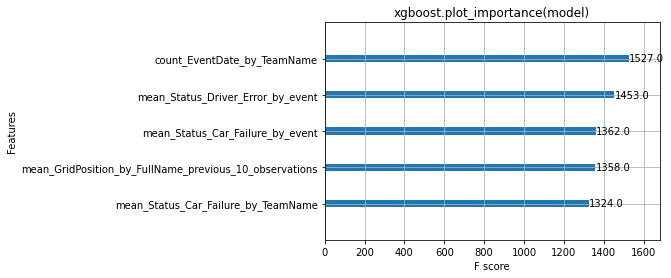

In [0]:
import shap
import numpy as np
import matplotlib.pylab as plt

xgb.plot_importance(pipeline1.steps[1][1],max_num_features=5)
plt.title("xgboost.plot_importance(model)")
plt.show()

In [0]:
%sh
sudo apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config

Reading package lists...
Building dependency tree...
Reading state information...
pkg-config is already the newest version (0.29.1-0ubuntu4).
pkg-config set to manually installed.
The following additional packages will be installed:
  fonts-liberation libann0 libcdt5 libcgraph6 libgail-common libgail18
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgts-0.7-5 libgts-bin libgvc6
  libgvc6-plugins-gtk libgvpr2 liblab-gamut1 libpathplan4 libpython3-dev
  libpython3.8-dev libxdot4 python3.8-dev
Suggested packages:
  graphviz-doc gvfs
The following NEW packages will be installed:
  fonts-liberation graphviz libann0 libcdt5 libcgraph6 libgail-common
  libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgts-0.7-5 libgts-bin libgvc6 libgvc6-plugins-gtk libgvpr2 liblab-gamut1
  libpathplan4 libpython3-dev libpython3.8-dev libxdot4 python3-dev
  python3.8-dev
0 upgraded, 23 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,322 kB of archives.
After this operat

In [0]:
plt.style.use('ggplot')
xgb.plot_tree(pipeline1.steps[1][1]);
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.779684 to fit


In [0]:
import graphviz

Out[35]: <AxesSubplot:>

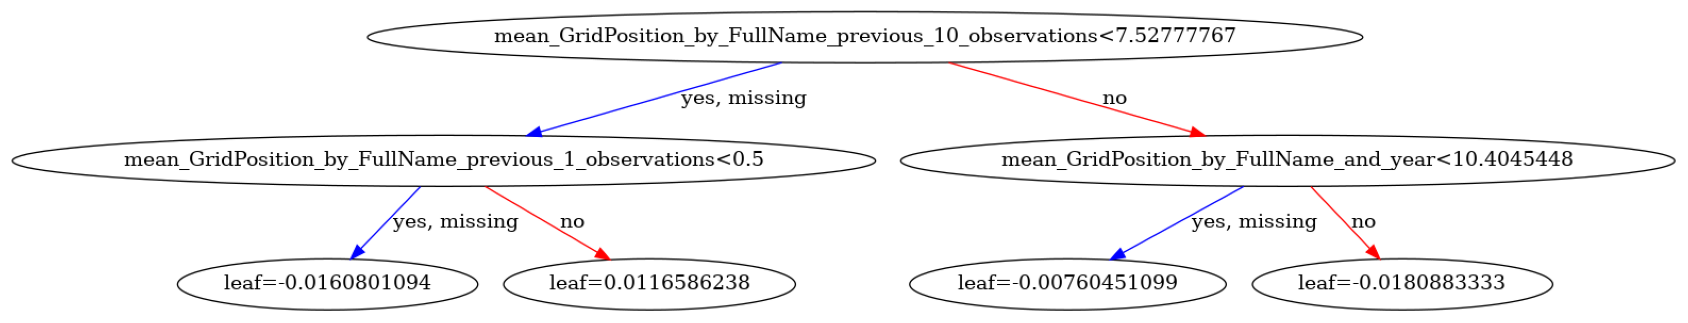

In [0]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(pipeline1.steps[1][1], num_trees=1, ax=ax)